<a href="https://colab.research.google.com/github/sritipeach1/FFPE-Brain-Tumor-Classification/blob/main/notebooks/01_ffpe_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0) Setup (paths, libs, folders)

In [ ]:
# --- standard libs
import os, gzip, io, re, json, math, urllib.request, urllib.error, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, roc_auc_score,
    confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV

# --- reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# --- repo-aware paths (works whether or not you've cloned the repo)
# If this notebook lives in /content/FFPE-Brain-Tumor-Classification/notebooks/,
# REPO will resolve to the parent repo folder.
try:
    import pathlib
    REPO = str(pathlib.Path.cwd().parents[0])  # parent of notebooks/
except Exception:
    REPO = "/content"  # fallback
DATA = f"{REPO}/data"
RESULTS = f"{REPO}/results"
os.makedirs(DATA, exist_ok=True)
os.makedirs(RESULTS, exist_ok=True)

plt.rcParams["figure.dpi"] = 130
print("REPO:", REPO)
print("DATA:", DATA)
print("RESULTS:", RESULTS)


REPO: /
DATA: //data
RESULTS: //results


1) Download GSE272042: TPM matrix + Series Matrix (metadata)

In [ ]:
# GEO provides both FTP and HTTP links; use HTTP as fallback in case FTP is blocked.
URL_TPM_FTP   = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE272nnn/GSE272042/suppl/GSE272042_tpmALL.csv.gz"
URL_TPM_HTTP  = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE272nnn/GSE272042/suppl/GSE272042_tpmALL.csv.gz"
URL_SER_FTP   = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE272nnn/GSE272042/matrix/GSE272042_series_matrix.txt.gz"
URL_SER_HTTP  = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE272nnn/GSE272042/matrix/GSE272042_series_matrix.txt.gz"

TPM_PATH    = f"{DATA}/GSE272042_tpmALL.csv.gz"
SERIES_PATH = f"{DATA}/GSE272042_series_matrix.txt.gz"

def _try_download(url, dest):
    try:
        print(f"Downloading: {url}")
        urllib.request.urlretrieve(url, dest)
        print("Saved:", dest)
        return True
    except Exception as e:
        print("Download failed:", e)
        return False

def download_if_missing(primary, fallback, dest):
    if os.path.exists(dest):
        print("Exists:", dest)
        return
    ok = _try_download(primary, dest)
    if not ok:
        _ = _try_download(fallback, dest)

download_if_missing(URL_TPM_FTP,  URL_TPM_HTTP,  TPM_PATH)
download_if_missing(URL_SER_FTP,  URL_SER_HTTP,  SERIES_PATH)


Downloading: ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE272nnn/GSE272042/suppl/GSE272042_tpmALL.csv.gz
Saved: //data/GSE272042_tpmALL.csv.gz
Downloading: ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE272nnn/GSE272042/matrix/GSE272042_series_matrix.txt.gz
Saved: //data/GSE272042_series_matrix.txt.gz


2) Load TPM matrix

In [ ]:
tpm = pd.read_csv(TPM_PATH, compression="gzip", index_col=0)
print("TPM shape (genes x samples):", tpm.shape)
display(tpm.iloc[:3, :16])


TPM shape (genes x samples): (40232, 153)


,126,134,140,156,157,159,160,161,171,219,232,274,280,294,322,138
MT-TF,8,11,9,13,8,6,3,12,0,30,3,3,3,13,6,8
MT-RNR1,1557,2399,1984,1007,2835,4330,2825,5246,4078,3535,1272,394,3920,2103,1640,1385
MT-TV,0,3,0,4,8,3,6,8,0,25,7,18,0,14,7,3


In [ ]:
# First 20 genes
display(tpm.iloc[:20, :5])


,126,134,140,156,157
MT-TF,8,11,9,13,8
MT-RNR1,1557,2399,1984,1007,2835
MT-TV,0,3,0,4,8
MT-RNR2,9468,9402,7450,2929,4305
MT-TL1,38,25,18,4,8
MT-ND1,148,72,79,66,94
MT-TI,6,0,0,0,3
MT-TQ,0,0,0,0,0
MT-TM,6,0,0,9,9
MT-ND2,64,38,33,42,50


3) Parse Series Matrix (metadata) → build labels

In [ ]:
#import gzip

#with gzip.open(SERIES_PATH, "rt", encoding="utf-8", errors="ignore") as fh:
    #for i, line in enumerate(fh):
        #if i < 50:  # first 50 lines
            #print(repr(line))


In [ ]:
def read_series_matrix(series_path):
    """
    Parse GEO Series Matrix file (tab-separated, one key per line).
    Returns DataFrame: rows = samples, columns = metadata fields.
    """
    fields = {}
    with gzip.open(series_path, "rt", encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            if not line.startswith("!Sample_"):
                continue
            parts = line.strip().split("\t")
            key = parts[0].replace("!Sample_", "")
            values = [v.strip('"') for v in parts[1:]]
            fields[key] = values

    # transpose: dict of field->list(sample values) → DataFrame with samples as rows
    meta = pd.DataFrame(fields)

    # geo_accession column should exist → set as index
    if "geo_accession" in meta.columns:
        meta.index = meta["geo_accession"]

    return meta

# run it
meta = read_series_matrix(SERIES_PATH)
print("META shape (samples x fields):", meta.shape)
display(meta.head(5).T.head(20))  # peek: 5 samples x first 20 fields


META shape (samples x fields): (153, 31)


geo_accession,GSM8391641,GSM8391642,GSM8391643,GSM8391644,GSM8391645
title,Sample 31,Sample 32,Sample 42,Sample 73,Sample 81
geo_accession,GSM8391641,GSM8391642,GSM8391643,GSM8391644,GSM8391645
status,Public on Jan 15 2025,Public on Jan 15 2025,Public on Jan 15 2025,Public on Jan 15 2025,Public on Jan 15 2025
submission_date,Jul 11 2024,Jul 11 2024,Jul 11 2024,Jul 11 2024,Jul 11 2024
last_update_date,Jan 15 2025,Jan 15 2025,Jan 15 2025,Jan 15 2025,Jan 15 2025
type,SRA,SRA,SRA,SRA,SRA
channel_count,1,1,1,1,1
source_name_ch1,Brain tumor,Brain tumor,Brain tumor,Brain tumor,Brain tumor
organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
characteristics_ch1,tissue: Brain tumor,tissue: Brain tumor,tissue: Brain tumor,tissue: Brain tumor,tissue: Brain tumor


In [ ]:
desc = meta["description"].fillna("").str.lower()

def map_to_class(s: str) -> str:
    # Oligodendroglioma (WHO 2021: implies IDHmut + 1p/19q codeleted)
    if "oligodendroglioma" in s or "1p/19q" in s:
        return "ODG_IDHmut_1p19q"
    # Astrocytoma (usually IDH-mutant if noted)
    if "astrocytoma" in s:
        if "idh" in s and "mut" in s:
            return "ASTRO_IDHmut"
        return "ASTRO_IDHmut"  # default astro → treat as IDHmut
    # Glioblastoma
    if "glioblastoma" in s or "gbm" in s:
        if "idh" in s and "mut" in s:
            return "OTHERS"  # rare case: GBM IDHmut → treat as outlier
        return "GBM_IDHwt"
    return "OTHERS"

labels = desc.apply(map_to_class)
labels.name = "label"

print("Class distribution:")
print(labels.value_counts())


Class distribution:
label
GBM_IDHwt           113
ASTRO_IDHmut         18
ODG_IDHmut_1p19q     12
OTHERS               10
Name: count, dtype: int64


4) Align samples between TPM and labels

In [ ]:
print("First 20 TPM column names:")
print(list(tpm.columns[:20]))


First 20 TPM column names:
['126', '134', '140', '156', '157', '159', '160', '161', '171', '219', '232', '274', '280', '294', '322', '138', '228', '286', '287', '293']


In [ ]:
print(meta[["title", "geo_accession"]].head(20))


                    title geo_accession
geo_accession                          
GSM8391641      Sample 31    GSM8391641
GSM8391642      Sample 32    GSM8391642
GSM8391643      Sample 42    GSM8391643
GSM8391644      Sample 73    GSM8391644
GSM8391645      Sample 81    GSM8391645
GSM8391646      Sample 95    GSM8391646
GSM8391647     Sample 158    GSM8391647
GSM8391648     Sample 166    GSM8391648
GSM8391649     Sample 199    GSM8391649
GSM8391650     Sample 208    GSM8391650
GSM8391651     Sample 214    GSM8391651
GSM8391652     Sample 236    GSM8391652
GSM8391653     Sample 249    GSM8391653
GSM8391654     Sample 253    GSM8391654
GSM8391655     Sample 416    GSM8391655
GSM8391656     Sample 466    GSM8391656
GSM8391657       Sample 3    GSM8391657
GSM8391658      Sample 12    GSM8391658
GSM8391659      Sample 16    GSM8391659
GSM8391660      Sample 19    GSM8391660


In [ ]:
# Build mapping: "Sample N" -> GSM accession
title_to_gsm = dict(zip(meta["title"], meta.index))

# Remap TPM columns
new_cols = []
for c in tpm.columns:
    sample_title = f"Sample {c}"
    if sample_title in title_to_gsm:
        new_cols.append(title_to_gsm[sample_title])
    else:
        new_cols.append(None)  # keep None if no mapping found

tpm.columns = new_cols

# Drop columns we couldn't map
tpm = tpm.loc[:, tpm.columns.notna()]

print("After remapping:")
print("TPM shape:", tpm.shape)
print("First 10 column names:", list(tpm.columns[:10]))


After remapping:
TPM shape: (40232, 153)
First 10 column names: ['GSM8391702', 'GSM8391703', 'GSM8391704', 'GSM8391705', 'GSM8391706', 'GSM8391707', 'GSM8391708', 'GSM8391709', 'GSM8391710', 'GSM8391711']


In [ ]:
common = [c for c in tpm.columns if c in labels.index]
print("Usable samples:", len(common))

X_raw = tpm[common].T     # samples x genes
y     = labels.loc[common]

print("y distribution:")
display(y.value_counts())
display(X_raw.iloc[:3, :5])


Usable samples: 153
y distribution:


,count
label,
GBM_IDHwt,113
ASTRO_IDHmut,18
ODG_IDHmut_1p19q,12
OTHERS,10


,MT-TF,MT-RNR1,MT-TV,MT-RNR2,MT-TL1
GSM8391702,8,1557,0,9468,38
GSM8391703,11,2399,3,9402,25
GSM8391704,9,1984,0,7450,18


5) Preprocess

keep genes with TPM>1 in ≥20% samples

log1p transform

select top-variance genes (e.g., up to 2000)

z-score after train/val/test split (to avoid leakag

In [ ]:
# 5.1 filter genes: keep genes expressed (TPM > 1) in >=20% samples
expr_rate = (X_raw > 1.0).sum(axis=0) / X_raw.shape[0]
keep_genes = expr_rate[expr_rate >= 0.20].index.tolist()
X1 = X_raw[keep_genes]

print("Genes before:", X_raw.shape[1], "→ after filtering:", len(keep_genes))

# 5.2 log1p transform
X2 = np.log1p(X1)

# 5.3 pick top variance genes
gene_var = X2.var(axis=0).sort_values(ascending=False)
TOP_K = min(2000, len(gene_var))
top_genes = gene_var.index[:TOP_K]
X_feat = X2[top_genes]

print("Final feature matrix shape:", X_feat.shape)
display(X_feat.iloc[:3, :10])


Genes before: 40232 → after filtering: 18061
Final feature matrix shape: (153, 2000)


,RNVU1-29,RNVU1-18,RNU1-27P,RNU1-2,RNU1-28P,RNU1-1,RNA5S1,RNU1-4,RNU1-3,SNORA10
GSM8391702,0.0,0.000000,0.0,6.862758,0.000000,0.0,6.161207,0.0,0.0,0.0
GSM8391703,0.0,0.000000,0.0,0.000000,7.430114,0.0,5.509388,0.0,0.0,0.0
GSM8391704,0.0,7.307202,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [ ]:
display(X_feat.iloc[:10, :10])

,RNVU1-29,RNVU1-18,RNU1-27P,RNU1-2,RNU1-28P,RNU1-1,RNA5S1,RNU1-4,RNU1-3,SNORA10
GSM8391702,0.000000,0.000000,0.000000,6.862758,0.000000,0.000000,6.161207,0.000000,0.000000,0.000000
GSM8391703,0.000000,0.000000,0.000000,0.000000,7.430114,0.000000,5.509388,0.000000,0.000000,0.000000
GSM8391704,0.000000,7.307202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GSM8391705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.888878,0.000000,0.000000,0.000000
GSM8391706,6.163315,6.161207,6.169611,6.182085,6.188264,6.139885,6.098074,6.192362,6.212606,5.594711
GSM8391707,7.186144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.285998,6.642487,5.351858
GSM8391708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.912655,0.000000,0.000000,4.343805
GSM8391709,0.000000,0.000000,0.000000,6.829794,0.000000,0.000000,4.969813,0.000000,0.000000,0.000000
GSM8391710,0.000000,6.933423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.330733
GSM8391711,5.730100,5.998937,5.560682,6.056784,5.556828,5.950643,0.000000,5.849325,5.910797,0.000000


6) Split → z-score on train → class weights

In [ ]:
# 6.1 stratified split: 70% train, 15% val, 15% test
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_feat, y, test_size=0.30, stratify=y, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=SEED
)

print("Split shapes (samples x features):")
print("  train:", X_train.shape, "| val:", X_val.shape, "| test:", X_test.shape)

# 6.2 standardize features: fit on TRAIN only, transform VAL/TEST (avoid leakage)
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr = scaler.fit_transform(X_train.values)
Xva = scaler.transform(X_val.values)
Xte = scaler.transform(X_test.values)

# For convenience keep DataFrame wrappers (optional)
Xtr = pd.DataFrame(Xtr, index=X_train.index, columns=X_train.columns)
Xva = pd.DataFrame(Xva, index=X_val.index,   columns=X_val.columns)
Xte = pd.DataFrame(Xte, index=X_test.index,  columns=X_test.columns)

# 6.3 class weights to mitigate imbalance
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train.values)
class_weight = {c: w for c, w in zip(classes, weights)}

print("\nClass counts (train):")
print(y_train.value_counts())
print("\nClass weights:")
print(class_weight)


Split shapes (samples x features):
  train: (107, 2000) | val: (23, 2000) | test: (23, 2000)

Class counts (train):
label
GBM_IDHwt           79
ASTRO_IDHmut        13
ODG_IDHmut_1p19q     8
OTHERS               7
Name: count, dtype: int64

Class weights:
{'ASTRO_IDHmut': np.float64(2.0576923076923075), 'GBM_IDHwt': np.float64(0.33860759493670883), 'ODG_IDHmut_1p19q': np.float64(3.34375), 'OTHERS': np.float64(3.8214285714285716)}


7) Train multinomial logistic regression + Platt calibration

In [ ]:
# 7.1 base logistic regression
base_lr = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500,
    class_weight=class_weight,
    n_jobs=-1,
    random_state=SEED
)

# fit on train
base_lr.fit(Xtr, y_train)

# 7.2 calibration on validation set (Platt sigmoid)
cal = CalibratedClassifierCV(base_lr, method="sigmoid", cv="prefit")
cal.fit(Xva, y_val)

# 7.3 evaluate on test set
y_pred = cal.predict(Xte)
y_proba = cal.predict_proba(Xte)

macro_f1 = f1_score(y_test, y_pred, average="macro")
bal_acc  = balanced_accuracy_score(y_test, y_pred)
y_test_bin = label_binarize(y_test, classes=cal.classes_)
auroc = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")

print("📊 Evaluation (Test set):")
print("Macro F1:", round(macro_f1, 4))
print("Balanced Accuracy:", round(bal_acc, 4))
print("OvR AUROC:", round(auroc, 4))
print("Classes:", list(cal.classes_))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


📊 Evaluation (Test set):
Macro F1: 0.5154
Balanced Accuracy: 0.4583
OvR AUROC: 0.7715
Classes: ['ASTRO_IDHmut', 'GBM_IDHwt', 'ODG_IDHmut_1p19q', 'OTHERS']


8) Plots: confusion matrix & reliability (macro-averaged)

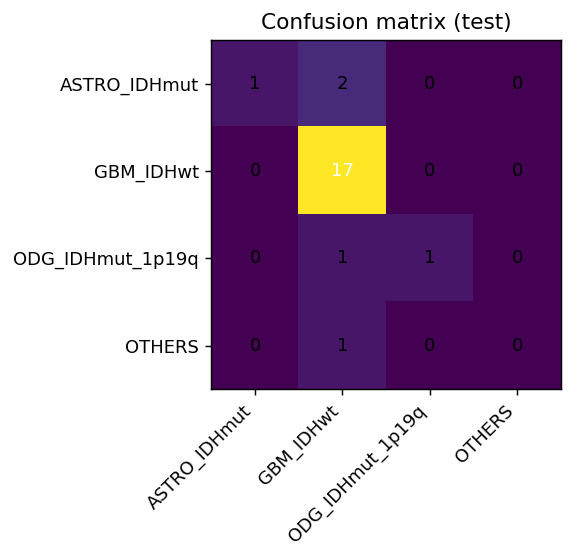

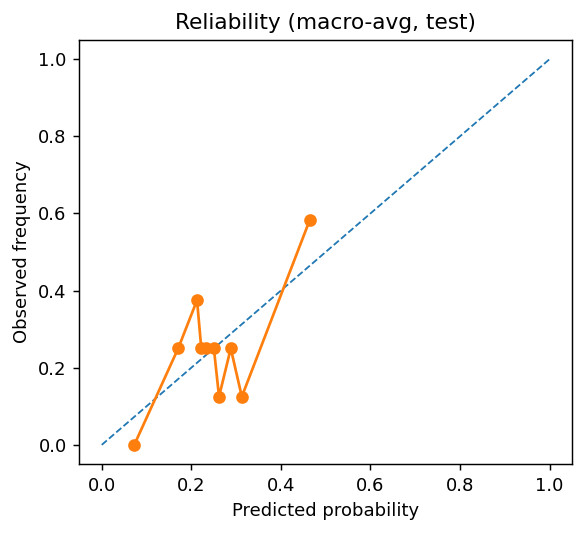

Saved files:
- //results/confusion_ffpe.png
- //results/reliability_ffpe.png
- //results/metrics_ffpe.csv
- //results/metrics_ffpe_per_class.csv


In [ ]:
# --- Step 8: Confusion matrix + Reliability (macro-avg) + Save metrics ---

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.calibration import calibration_curve
import numpy as np
import pandas as pd
import os

os.makedirs(RESULTS, exist_ok=True)

# 8.1 Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=cal.classes_)
fig, ax = plt.subplots(figsize=(4.8, 4.4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion matrix (test)")
ax.set_xticks(range(len(cal.classes_))); ax.set_yticks(range(len(cal.classes_)))
ax.set_xticklabels(cal.classes_, rotation=45, ha="right"); ax.set_yticklabels(cal.classes_)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, cm[i, j], ha="center", va="center",
            color=("white" if cm[i, j] > cm.max()/2 else "black"))
fig.tight_layout()
cm_path = f"{RESULTS}/confusion_ffpe.png"
plt.savefig(cm_path, bbox_inches="tight")
plt.show()

# 8.2 Reliability diagram (macro-averaged across classes)
# For each class, compute calibration curve vs. its one-vs-rest targets, then average curves.
true_all, pred_all = [], []
for ci, c in enumerate(cal.classes_):
    t = (y_test.values == c).astype(int)
    p = y_proba[:, ci]
    tru, pre = calibration_curve(t, p, n_bins=10, strategy="quantile")
    true_all.append(tru); pred_all.append(pre)

tru_m = np.mean(np.vstack(true_all), axis=0)
pre_m = np.mean(np.vstack(pred_all), axis=0)

plt.figure(figsize=(4.6, 4.2))
plt.plot([0,1],[0,1],"--", linewidth=1)
plt.plot(pre_m, tru_m, marker="o")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability (macro-avg, test)")
rel_path = f"{RESULTS}/reliability_ffpe.png"
plt.tight_layout()
plt.savefig(rel_path, bbox_inches="tight")
plt.show()

# 8.3 Save metrics (overall + per-class report)
overall_df = pd.DataFrame([{
    "macro_f1": round(macro_f1, 6),
    "balanced_accuracy": round(bal_acc, 6),
    "ovr_auroc": round(auroc, 6),
    "n_test": int(len(y_test))
}])
overall_path = f"{RESULTS}/metrics_ffpe.csv"
overall_df.to_csv(overall_path, index=False)

# Per-class precision/recall/F1
report_dict = classification_report(y_test, y_pred, labels=cal.classes_, output_dict=True, zero_division=0)
per_class_df = pd.DataFrame(report_dict).T  # includes per-class rows
per_class_path = f"{RESULTS}/metrics_ffpe_per_class.csv"
per_class_df.to_csv(per_class_path)

print("Saved files:")
print("-", cm_path)
print("-", rel_path)
print("-", overall_path)
print("-", per_class_path)


In [ ]:
import pandas as pd

overall = pd.read_csv(f"{RESULTS}/metrics_ffpe.csv")
per_cls = pd.read_csv(f"{RESULTS}/metrics_ffpe_per_class.csv")

print("Overall metrics:")
display(overall)

print("Per-class metrics (top rows):")
# The classification_report adds rows like 'macro avg', 'weighted avg' too.
display(per_cls.head(10))


Overall metrics:


,macro_f1,balanced_accuracy,ovr_auroc,n_test
0,0.515351,0.458333,0.771534,23


Per-class metrics (top rows):


,Unnamed: 0,precision,recall,f1-score,support
0,ASTRO_IDHmut,1.000000,0.333333,0.500000,3.000000
1,GBM_IDHwt,0.809524,1.000000,0.894737,17.000000
2,ODG_IDHmut_1p19q,1.000000,0.500000,0.666667,2.000000
3,OTHERS,0.000000,0.000000,0.000000,1.000000
4,accuracy,0.826087,0.826087,0.826087,0.826087
5,macro avg,0.702381,0.458333,0.515351,23.000000
6,weighted avg,0.815735,0.826087,0.784516,23.000000


In [ ]:
display(overall.round(4))

cols = [c for c in per_cls.columns if per_cls[c].dtype == "float64"]
display(per_cls.round({c: 4 for c in cols}))


,macro_f1,balanced_accuracy,ovr_auroc,n_test
0,0.5154,0.4583,0.7715,23


,Unnamed: 0,precision,recall,f1-score,support
0,ASTRO_IDHmut,1.0000,0.3333,0.5000,3.0000
1,GBM_IDHwt,0.8095,1.0000,0.8947,17.0000
2,ODG_IDHmut_1p19q,1.0000,0.5000,0.6667,2.0000
3,OTHERS,0.0000,0.0000,0.0000,1.0000
4,accuracy,0.8261,0.8261,0.8261,0.8261
5,macro avg,0.7024,0.4583,0.5154,23.0000
6,weighted avg,0.8157,0.8261,0.7845,23.0000


DGE


1) Prep: log2(TPM+1) and imports

In [28]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os

# log-scale expression for DGE (samples × genes)
expr_log = np.log2(X_raw + 1.0)
print(expr_log.shape)
print(y.value_counts())


(153, 40232)
label
GBM_IDHwt           113
ASTRO_IDHmut         18
ODG_IDHmut_1p19q     12
OTHERS               10
Name: count, dtype: int64


2) DGE helper (Welch t-test + BH-FDR + effect sizes)

In [29]:
def dge_two_group(expr_log_df: pd.DataFrame, labels: pd.Series, group_a: str, group_b: str):
    """
    Differential expression on log2(TPM+1) between group_a and group_b.
    Returns: DataFrame indexed by gene with log2FC(A-B), t, pval, FDR, Cohen's d.
    """
    A_idx = labels[labels == group_a].index
    B_idx = labels[labels == group_b].index
    A = expr_log_df.loc[A_idx]
    B = expr_log_df.loc[B_idx]

    meanA, meanB = A.mean(axis=0), B.mean(axis=0)
    log2fc = meanA - meanB

    tvals, pvals = [], []
    for g in expr_log_df.columns:
        t, p = stats.ttest_ind(A[g], B[g], equal_var=False, nan_policy="omit")
        tvals.append(t); pvals.append(p)
    tvals, pvals = np.array(tvals), np.array(pvals)

    # Benjamini–Hochberg FDR
    _, fdr, _, _ = multipletests(pvals, method="fdr_bh")

    # Cohen's d (pooled sd)
    sA2, sB2 = A.var(axis=0, ddof=1), B.var(axis=0, ddof=1)
    nA, nB = A.shape[0], B.shape[0]
    sp = np.sqrt(((nA-1)*sA2 + (nB-1)*sB2) / (nA + nB - 2))
    cohen_d = (meanA - meanB) / sp.replace(0, np.nan)

    out = pd.DataFrame({
        "gene": expr_log_df.columns,
        "log2FC": log2fc.values,
        "t": tvals,
        "pval": pvals,
        "FDR": fdr,
        "cohen_d": cohen_d.values
    }).set_index("gene").sort_values("FDR")
    return out


3) Run three contrasts & save CSVs

In [30]:
# (1) GBM vs REST (pool non-GBM)
y_gbmrest = y.copy()
y_gbmrest.loc[y_gbmrest != "GBM_IDHwt"] = "REST"
dge_gbm_vs_rest = dge_two_group(expr_log, y_gbmrest, "GBM_IDHwt", "REST")
dge_gbm_vs_rest.to_csv(f"{RESULTS}/dge_GBM_vs_REST.csv")

# (2) ASTRO vs GBM
dge_astro_vs_gbm = dge_two_group(expr_log, y, "ASTRO_IDHmut", "GBM_IDHwt")
dge_astro_vs_gbm.to_csv(f"{RESULTS}/dge_ASTRO_vs_GBM.csv")

# (3) ODG vs GBM
dge_odg_vs_gbm = dge_two_group(expr_log, y, "ODG_IDHmut_1p19q", "GBM_IDHwt")
dge_odg_vs_gbm.to_csv(f"{RESULTS}/dge_ODG_vs_GBM.csv")

print("Saved:",
      f"{RESULTS}/dge_GBM_vs_REST.csv",
      f"{RESULTS}/dge_ASTRO_vs_GBM.csv",
      f"{RESULTS}/dge_ODG_vs_GBM.csv",
      sep="\n- ")


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Saved:
- //results/dge_GBM_vs_REST.csv
- //results/dge_ASTRO_vs_GBM.csv
- //results/dge_ODG_vs_GBM.csv


In [31]:
import pandas as pd

# Load each result
dge_gbm = pd.read_csv(f"{RESULTS}/dge_GBM_vs_REST.csv", index_col=0)
dge_astro = pd.read_csv(f"{RESULTS}/dge_ASTRO_vs_GBM.csv", index_col=0)
dge_odg = pd.read_csv(f"{RESULTS}/dge_ODG_vs_GBM.csv", index_col=0)

# Quick peek
print("GBM vs REST (top 5):")
display(dge_gbm.head())

print("ASTRO vs GBM (top 5):")
display(dge_astro.head())

print("ODG vs GBM (top 5):")
display(dge_odg.head())


GBM vs REST (top 5):


,log2FC,t,pval,FDR,cohen_d
gene,,,,,
MT-TF,0.285896,0.939833,0.350627,NaN,0.173525
MT-RNR1,0.057525,0.274258,0.784744,NaN,0.051550
MT-TV,-0.212132,-0.663697,0.509177,NaN,-0.124089
MT-RNR2,-0.296975,-1.800371,0.076687,NaN,-0.351986
MT-TL1,-0.419894,-1.161199,0.250046,NaN,-0.227518


ASTRO vs GBM (top 5):


,log2FC,t,pval,FDR,cohen_d
gene,,,,,
MT-TF,-0.443561,-1.129782,0.269873,NaN,-0.272136
MT-RNR1,-0.284696,-1.291979,0.207034,NaN,-0.266018
MT-TV,0.017796,0.040060,0.968401,NaN,0.010449
MT-RNR2,0.194371,1.060569,0.299114,NaN,0.242800
MT-TL1,0.270311,0.544143,0.591924,NaN,0.149645


ODG vs GBM (top 5):


,log2FC,t,pval,FDR,cohen_d
gene,,,,,
MT-TF,0.066677,0.118655,0.907381,NaN,0.040023
MT-RNR1,-0.008412,-0.019948,0.984400,NaN,-0.007416
MT-TV,0.380115,0.652731,0.525440,NaN,0.221276
MT-RNR2,0.321683,0.966569,0.352440,NaN,0.380237
MT-TL1,1.088968,1.716053,0.110433,NaN,0.601297


4) Volcano plots (FDR < 0.05 & |log2FC| ≥ 1 by default)

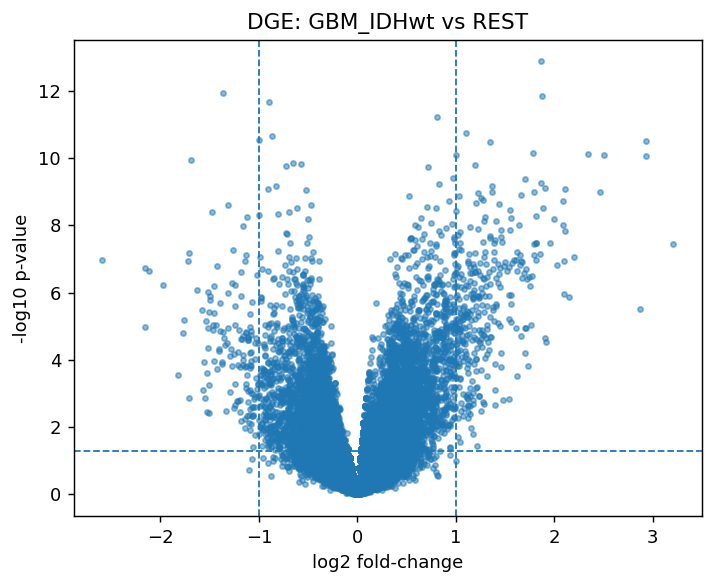

Saved: //results/volcano_GBM_vs_REST.png


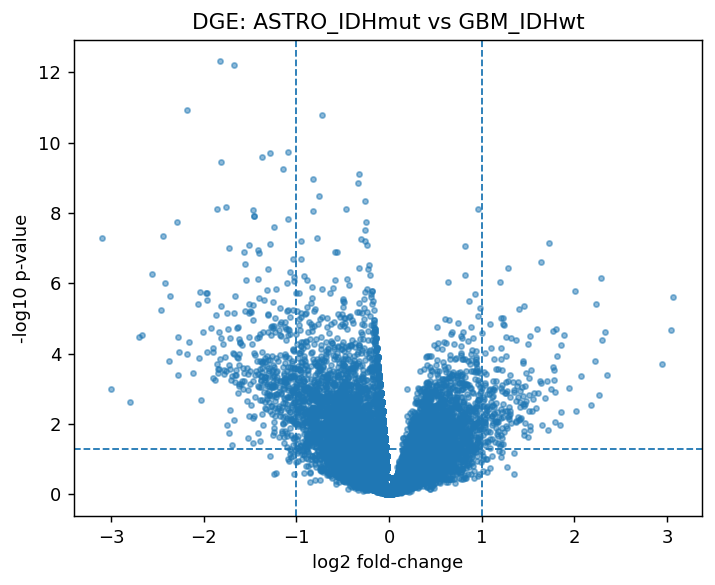

Saved: //results/volcano_ASTRO_vs_GBM.png


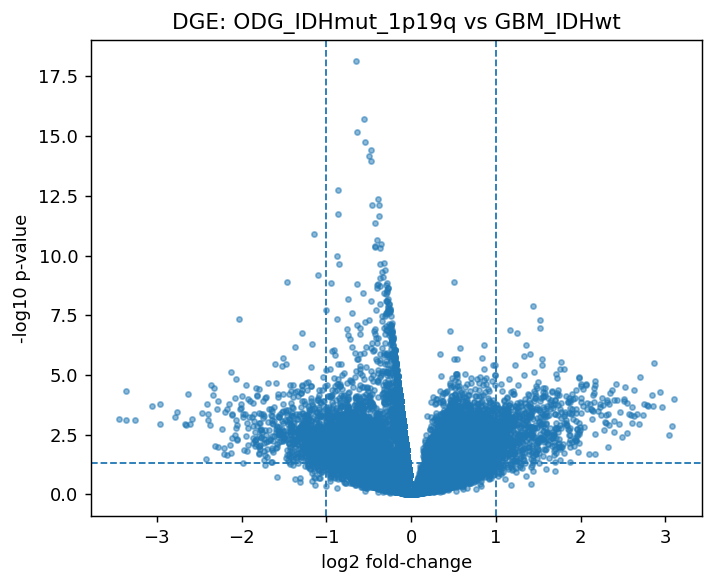

Saved: //results/volcano_ODG_vs_GBM.png


In [33]:
def volcano(df, title, out_png, fdr_thresh=0.05, lfc_thresh=1.0):
    x = df["log2FC"].values
    p = df["pval"].clip(lower=1e-300).values
    yv = -np.log10(p)
    sig = (df["FDR"] < fdr_thresh) & (np.abs(df["log2FC"]) >= lfc_thresh)

    plt.figure(figsize=(5.6,4.6))
    plt.scatter(x[~sig], yv[~sig], s=8, alpha=0.5)
    plt.scatter(x[sig],  yv[sig],  s=10, alpha=0.9)
    plt.axhline(-np.log10(0.05), ls="--", lw=1)
    plt.axvline( lfc_thresh,  ls="--", lw=1); plt.axvline(-lfc_thresh, ls="--", lw=1)
    plt.xlabel("log2 fold-change"); plt.ylabel("-log10 p-value")
    plt.title(title); plt.tight_layout()
    plt.savefig(out_png, dpi=140, bbox_inches="tight"); plt.show()
    print("Saved:", out_png)

volcano(dge_gbm_vs_rest, "DGE: GBM_IDHwt vs REST", f"{RESULTS}/volcano_GBM_vs_REST.png")
volcano(dge_astro_vs_gbm, "DGE: ASTRO_IDHmut vs GBM_IDHwt", f"{RESULTS}/volcano_ASTRO_vs_GBM.png")
volcano(dge_odg_vs_gbm, "DGE: ODG_IDHmut_1p19q vs GBM_IDHwt", f"{RESULTS}/volcano_ODG_vs_GBM.png")


5) (Optional) GSEA-ready ranked lists

In [34]:
def save_rnk(df, fname, score_col="t"):
    rnk = df[[score_col]].rename(columns={score_col: "score"}).sort_values("score", ascending=False)
    rnk.to_csv(fname, sep="\t", header=False)
    print("Saved:", fname)

save_rnk(dge_gbm_vs_rest, f"{RESULTS}/gbm_vs_rest.t.rnk", "t")
save_rnk(dge_astro_vs_gbm, f"{RESULTS}/astro_vs_gbm.t.rnk", "t")
save_rnk(dge_odg_vs_gbm, f"{RESULTS}/odg_vs_gbm.t.rnk", "t")


Saved: //results/gbm_vs_rest.t.rnk
Saved: //results/astro_vs_gbm.t.rnk
Saved: //results/odg_vs_gbm.t.rnk


In [35]:
# Example: load GBM vs REST ranked list
rnk_gbm = pd.read_csv(f"{RESULTS}/gbm_vs_rest.t.rnk", sep="\t", header=None, names=["gene", "score"])
print("Shape:", rnk_gbm.shape)
display(rnk_gbm.head(10))   # top 10 genes


Shape: (40232, 2)


,gene,score
0,SHOX2,8.683455
1,H3C7,8.315172
2,C6orf141,7.937380
3,IGFBP2,7.907958
4,PAFAH1B1P2,7.893108
5,ATF5,7.835087
6,H3C8,7.832259
7,CALD1,7.546913
8,VEGFA,7.450547
9,LAMB4,7.412848


In [36]:
# Load ASTRO vs GBM ranked list
rnk_astro = pd.read_csv(f"{RESULTS}/astro_vs_gbm.t.rnk", sep="\t", header=None, names=["gene", "score"])
print("ASTRO vs GBM ranked list:")
display(rnk_astro.head(10))




ASTRO vs GBM ranked list:


,gene,score
0,IRX2-DT,7.028259
1,ZDHHC2,6.928524
2,SLITRK5,6.762164
3,PDCD4,6.575041
4,KLRC4,6.515377
5,KLRC3,6.425110
6,SMOC1,6.119621
7,ZC3H12B,6.111476
8,RAPGEF2,6.098986
9,MYH14,6.044934


In [37]:
# Load ODG vs GBM ranked list
rnk_odg = pd.read_csv(f"{RESULTS}/odg_vs_gbm.t.rnk", sep="\t", header=None, names=["gene", "score"])
print("ODG vs GBM ranked list:")
display(rnk_odg.head(10))

ODG vs GBM ranked list:


,gene,score
0,EMC4,9.402480
1,NUDT7,7.553412
2,CHRDL1,7.387283
3,ZNF727,7.324258
4,ABCC8,7.292237
5,ZNF391,7.189165
6,ARMC1,7.152580
7,MIR1250,7.115486
8,ST6GAL2,7.042081
9,CTTNBP2,7.005264


Quick peek at top genes (nice for the report)

In [38]:
print("Top 10 (GBM vs REST) by FDR:")
display(dge_gbm_vs_rest.head(10))

print("Top 10 (ASTRO vs GBM) by FDR:")
display(dge_astro_vs_gbm.head(10))

print("Top 10 (ODG vs GBM) by FDR:")
display(dge_odg_vs_gbm.head(10))


Top 10 (GBM vs REST) by FDR:


,log2FC,t,pval,FDR,cohen_d
gene,,,,,
MT-TF,0.285896,0.939833,0.350627,NaN,0.173525
MT-RNR1,0.057525,0.274258,0.784744,NaN,0.051550
MT-TV,-0.212132,-0.663697,0.509177,NaN,-0.124089
MT-RNR2,-0.296975,-1.800371,0.076687,NaN,-0.351986
MT-TL1,-0.419894,-1.161199,0.250046,NaN,-0.227518
MT-ND1,-0.172213,-0.821164,0.414636,NaN,-0.158120
MT-TI,0.376007,2.351413,0.020665,NaN,0.363529
MT-TQ,0.263416,1.219971,0.225965,NaN,0.205031
MT-TM,0.173935,0.515630,0.607918,NaN,0.099575


Top 10 (ASTRO vs GBM) by FDR:


,log2FC,t,pval,FDR,cohen_d
gene,,,,,
MT-TF,-0.443561,-1.129782,0.269873,NaN,-0.272136
MT-RNR1,-0.284696,-1.291979,0.207034,NaN,-0.266018
MT-TV,0.017796,0.040060,0.968401,NaN,0.010449
MT-RNR2,0.194371,1.060569,0.299114,NaN,0.242800
MT-TL1,0.270311,0.544143,0.591924,NaN,0.149645
MT-ND1,-0.058444,-0.240499,0.811949,NaN,-0.055889
MT-TI,-0.340886,-1.564580,0.128774,NaN,-0.316199
MT-TQ,-0.590954,-2.802342,0.007832,NaN,-0.463093
MT-TM,-0.067240,-0.133621,0.894975,NaN,-0.038537


Top 10 (ODG vs GBM) by FDR:


,log2FC,t,pval,FDR,cohen_d
gene,,,,,
MT-TF,0.066677,0.118655,0.907381,NaN,0.040023
MT-RNR1,-0.008412,-0.019948,0.984400,NaN,-0.007416
MT-TV,0.380115,0.652731,0.525440,NaN,0.221276
MT-RNR2,0.321683,0.966569,0.352440,NaN,0.380237
MT-TL1,1.088968,1.716053,0.110433,NaN,0.601297
MT-ND1,0.451444,1.079901,0.300800,NaN,0.411839
MT-TI,-0.358770,-1.447068,0.166929,NaN,-0.329952
MT-TQ,0.088425,0.192073,0.850688,NaN,0.065061
MT-TM,-0.098710,-0.182016,0.858340,NaN,-0.057820
